Self Training Notebook on Vision Transformer for image classification

In [1]:
# 100th image inside the ex dataset-
from datasets import load_dataset
ds = load_dataset('beans')
ex = ds['train'][100] # choosing the 100th image of the training datasets


c:\Users\USER\anaconda3\envs\llm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset beans (C:/Users/USER/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791)
100%|██████████| 3/3 [00:00<00:00, 667.53it/s]


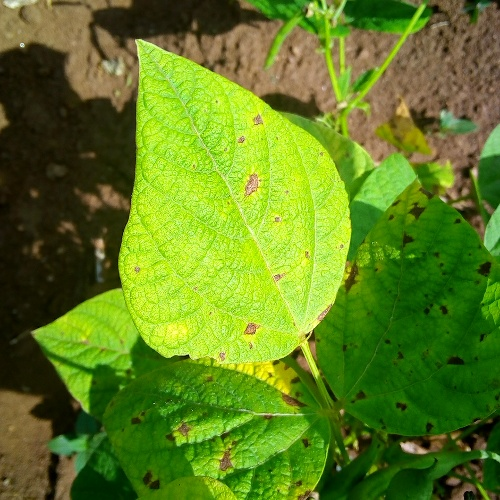

In [2]:
# image dataset

ex['image']

In [3]:
labels = ds['train'].features['labels']
labels

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

In [4]:
labels.int2str(ex['labels'])

'angular_leaf_spot'

Loading cached processed dataset at C:\Users\USER\.cache\huggingface\datasets\beans\default\0.0.0\90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791\cache-661debf1fc5b8190.arrow
Loading cached processed dataset at C:\Users\USER\.cache\huggingface\datasets\beans\default\0.0.0\90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791\cache-d9d8635069978cb1.arrow
Loading cached processed dataset at C:\Users\USER\.cache\huggingface\datasets\beans\default\0.0.0\90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791\cache-9487341e98842d51.arrow


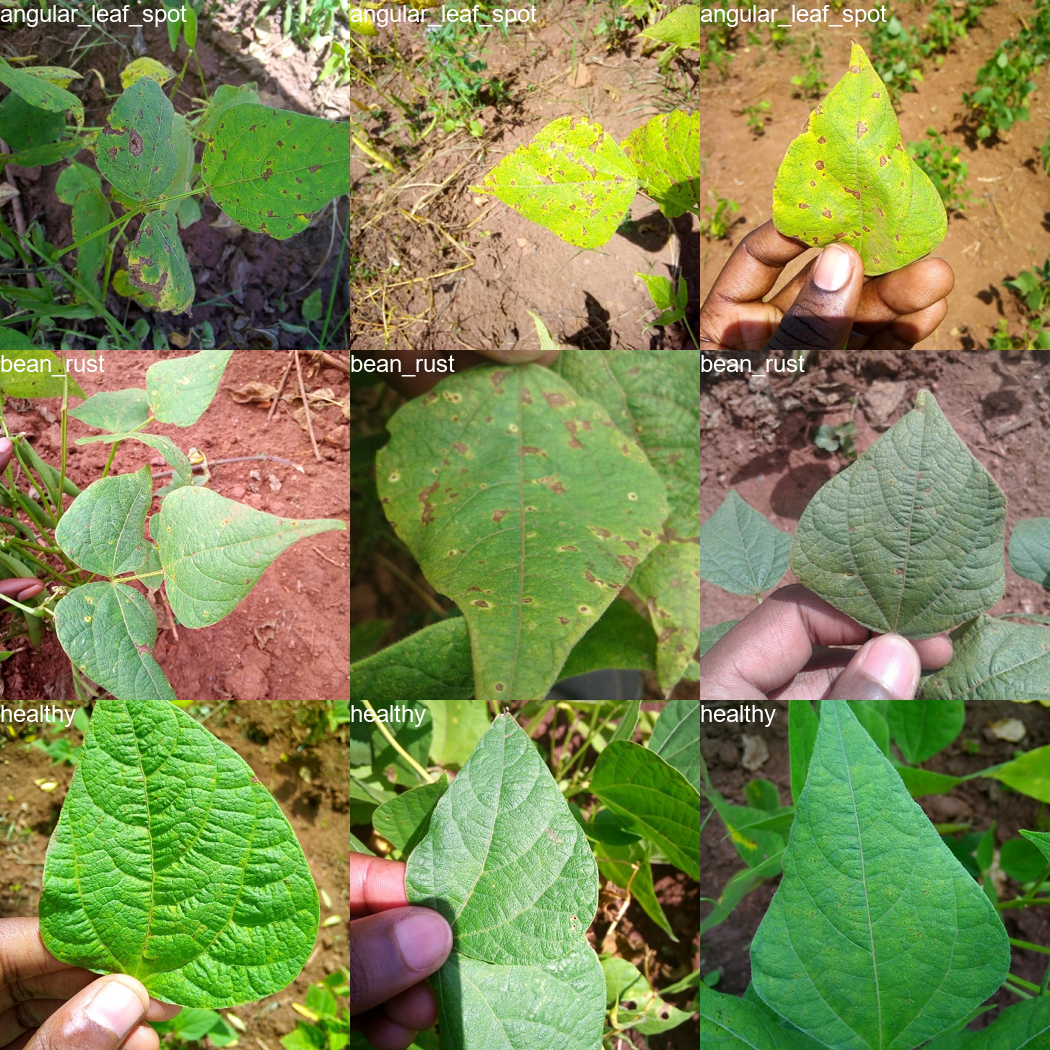

In [5]:
from transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor
import random
from PIL import ImageDraw, ImageFont, Image
# showing the different examples based on VIT
def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("arial.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255),font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

In [6]:
from transformers import ViTFeatureExtractor

path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(path)

c:\Users\USER\anaconda3\envs\llm\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [7]:
feature_extractor # the configuration of the feature extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [8]:
image = ex['image']



To process an image, simply pass it to the feature extractor's call function. This will return a dict containing pixel values, which is the numeric representation of your image that we'll pass to the model.

We get a numpy array by default, but if we add the return_tensors='pt' argument, we'll get back torch tensors instead.


In [9]:
feature_extractor(image, return_tensors = 'pt')

{'pixel_values': tensor([[[[ 0.1373,  0.2392,  0.4667,  ..., -0.7020, -0.7725, -0.8667],
          [ 0.1765,  0.2706,  0.5373,  ..., -0.3412, -0.5686, -0.8275],
          [ 0.1843,  0.1216,  0.2549,  ..., -0.1059, -0.3882, -0.7569],
          ...,
          [-0.2706, -0.1294, -0.0980,  ..., -0.3882, -0.6549, -0.7176],
          [-0.1765, -0.1059, -0.1529,  ..., -0.3490, -0.6471, -0.6392],
          [-0.1765, -0.1608, -0.2000,  ..., -0.3804, -0.6863, -0.7020]],

         [[ 0.0353,  0.1686,  0.4588,  ..., -0.7647, -0.8275, -0.8902],
          [ 0.0588,  0.1843,  0.5137,  ..., -0.4667, -0.6471, -0.8667],
          [ 0.0510,  0.0196,  0.2000,  ..., -0.2549, -0.5059, -0.8275],
          ...,
          [-0.3804, -0.2314, -0.2000,  ..., -0.4039, -0.5765, -0.6157],
          [-0.2863, -0.2235, -0.2627,  ..., -0.4824, -0.7020, -0.6627],
          [-0.2941, -0.2863, -0.3176,  ..., -0.4980, -0.7647, -0.7569]],

         [[-0.3647, -0.1373,  0.2471,  ..., -0.8667, -0.9294, -0.9922],
          [-0



While we could call ds.map and apply this to every example at once, this can be very slow, especially if you use a larger dataset. Instead, we'll apply a transform to the dataset. Transforms are only applied to examples as you index them.

First, though, we'll need to update our last function to accept a batch of data, as that's what ds.with_transform expects.


In [10]:
ds = load_dataset('beans')

def transform(example_batch):
    inputs = feature_extractor([x for x in example_batch['image']],return_tensors = 'pt')

    inputs['labels'] = example_batch['labels']

    return inputs 

Found cached dataset beans (C:/Users/USER/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791)
100%|██████████| 3/3 [00:00<00:00, 857.67it/s]


In [11]:
prepared_ds = ds.with_transform(transform)

Training Time!

The data is processed and we are ready to start setting up the training pipeline. We will make use of 🤗's Trainer, but that'll require us to do a few things first:

    Define a collate function.

    Define an evaluation metric. During training, the model should be evaluated on its prediction accuracy. We should define a compute_metrics function accordingly.

    Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.

    Define the training configuration.

After having fine-tuned the model, we will correctly evaluate it on the evaluation data and verify that it has indeed learned to correctly classify our images

Define our data collator

Batches are coming in as lists of dicts, so we just unpack + stack those into batch tensors.

We return a batch dict from our collate_fn so we can simply **unpack the inputs to our model later. ✨

In [12]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
        
    }

Define an evaluation metric

Here, we load the accuracy metric from datasets, and then write a function that takes in a model prediction + computes the accuracy.

In [13]:
import numpy as np

from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions,axis =1), references= p.label_ids)


C:\Users\USER\AppData\Local\Temp\ipykernel_45404\917707527.py:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


Now we can load our pretrained model. We'll add num_labels on init to make sure the model creates a classification head with the right number of units. We'll also include the id2label and label2id mappings so we have human readable labels in the 🤗 hub widget if we choose to push_to_hub.

In [14]:
from transformers import ViTForImageClassification
labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




We're almost ready to train! The last thing we'll do before that is set up the training configuration by defining TrainingArguments.

Most of these are pretty self-explanatory, but one that is quite important here is remove_unused_columns=False. This one will drop any features not used by the model's call function. By default it's True because usually its ideal to drop unused feature columns, as it makes it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

What I'm trying to say is that you'll have a bad time if you forget to set remove_unused_columns=False.


In [16]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans-demo-v5",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to = 'tensorboard',
  load_best_model_at_end=True,
)

In [17]:
from transformers import Trainer

trainer = Trainer(
    model = model,
    args = training_args,
    data_collator = collate_fn,
    compute_metrics = compute_metrics,
    train_dataset = prepared_ds["train"],
    eval_dataset = prepared_ds["validation"],
    tokenizer = feature_extractor
)

In [18]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

c:\Users\USER\anaconda3\envs\llm\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  4%|▍         | 10/260 [00:08<01:38,  2.54it/s]

{'loss': 0.8898, 'learning_rate': 0.00019230769230769233, 'epoch': 0.15}


  8%|▊         | 20/260 [00:11<01:18,  3.07it/s]

{'loss': 0.433, 'learning_rate': 0.00018461538461538463, 'epoch': 0.31}


 12%|█▏        | 30/260 [00:14<01:15,  3.06it/s]

{'loss': 0.3104, 'learning_rate': 0.00017692307692307693, 'epoch': 0.46}


 15%|█▌        | 40/260 [00:18<01:11,  3.07it/s]

{'loss': 0.1744, 'learning_rate': 0.00016923076923076923, 'epoch': 0.62}


 19%|█▉        | 50/260 [00:21<01:07,  3.09it/s]

{'loss': 0.2593, 'learning_rate': 0.00016153846153846155, 'epoch': 0.77}


 23%|██▎       | 60/260 [00:24<01:05,  3.06it/s]

{'loss': 0.1786, 'learning_rate': 0.00015384615384615385, 'epoch': 0.92}


 27%|██▋       | 70/260 [00:28<01:04,  2.94it/s]

{'loss': 0.119, 'learning_rate': 0.00014615384615384615, 'epoch': 1.08}


 31%|███       | 80/260 [00:31<01:02,  2.88it/s]

{'loss': 0.0925, 'learning_rate': 0.00013846153846153847, 'epoch': 1.23}


 35%|███▍      | 90/260 [00:35<00:58,  2.89it/s]

{'loss': 0.0772, 'learning_rate': 0.00013076923076923077, 'epoch': 1.38}


 38%|███▊      | 100/260 [00:38<00:55,  2.90it/s]

{'loss': 0.1173, 'learning_rate': 0.0001230769230769231, 'epoch': 1.54}


                                                 
 38%|███▊      | 100/260 [00:40<00:55,  2.90it/s]

{'eval_loss': 0.04692938178777695, 'eval_accuracy': 0.9924812030075187, 'eval_runtime': 2.2579, 'eval_samples_per_second': 58.903, 'eval_steps_per_second': 7.529, 'epoch': 1.54}


 42%|████▏     | 110/260 [00:46<00:59,  2.51it/s]

{'loss': 0.0492, 'learning_rate': 0.00011538461538461538, 'epoch': 1.69}


 46%|████▌     | 120/260 [00:49<00:49,  2.83it/s]

{'loss': 0.0995, 'learning_rate': 0.0001076923076923077, 'epoch': 1.85}


 50%|█████     | 130/260 [00:53<00:41,  3.16it/s]

{'loss': 0.0816, 'learning_rate': 0.0001, 'epoch': 2.0}


 54%|█████▍    | 140/260 [00:56<00:42,  2.85it/s]

{'loss': 0.0401, 'learning_rate': 9.230769230769232e-05, 'epoch': 2.15}


 58%|█████▊    | 150/260 [01:00<00:39,  2.82it/s]

{'loss': 0.0348, 'learning_rate': 8.461538461538461e-05, 'epoch': 2.31}


 62%|██████▏   | 160/260 [01:03<00:35,  2.85it/s]

{'loss': 0.0501, 'learning_rate': 7.692307692307693e-05, 'epoch': 2.46}


 65%|██████▌   | 170/260 [01:07<00:31,  2.84it/s]

{'loss': 0.0151, 'learning_rate': 6.923076923076924e-05, 'epoch': 2.62}


 69%|██████▉   | 180/260 [01:10<00:28,  2.85it/s]

{'loss': 0.0381, 'learning_rate': 6.153846153846155e-05, 'epoch': 2.77}


 73%|███████▎  | 190/260 [01:14<00:24,  2.85it/s]

{'loss': 0.032, 'learning_rate': 5.384615384615385e-05, 'epoch': 2.92}


 77%|███████▋  | 200/260 [01:17<00:20,  2.89it/s]

{'loss': 0.0136, 'learning_rate': 4.615384615384616e-05, 'epoch': 3.08}


                                                 
 77%|███████▋  | 200/260 [01:19<00:20,  2.89it/s]

{'eval_loss': 0.026703858748078346, 'eval_accuracy': 0.9924812030075187, 'eval_runtime': 2.283, 'eval_samples_per_second': 58.256, 'eval_steps_per_second': 7.446, 'epoch': 3.08}


 81%|████████  | 210/260 [01:24<00:19,  2.52it/s]

{'loss': 0.013, 'learning_rate': 3.846153846153846e-05, 'epoch': 3.23}


 85%|████████▍ | 220/260 [01:28<00:14,  2.85it/s]

{'loss': 0.012, 'learning_rate': 3.0769230769230774e-05, 'epoch': 3.38}


 88%|████████▊ | 230/260 [01:32<00:10,  2.85it/s]

{'loss': 0.0121, 'learning_rate': 2.307692307692308e-05, 'epoch': 3.54}


 92%|█████████▏| 240/260 [01:35<00:07,  2.83it/s]

{'loss': 0.0117, 'learning_rate': 1.5384615384615387e-05, 'epoch': 3.69}


 96%|█████████▌| 250/260 [01:39<00:03,  2.85it/s]

{'loss': 0.0109, 'learning_rate': 7.692307692307694e-06, 'epoch': 3.85}


100%|██████████| 260/260 [01:42<00:00,  3.19it/s]

{'loss': 0.011, 'learning_rate': 0.0, 'epoch': 4.0}


100%|██████████| 260/260 [01:42<00:00,  2.52it/s]


{'train_runtime': 102.9778, 'train_samples_per_second': 40.164, 'train_steps_per_second': 2.525, 'train_loss': 0.12216116227209568, 'epoch': 4.0}
***** train metrics *****
  epoch                    =        4.0
  train_loss               =     0.1222
  train_runtime            = 0:01:42.97
  train_samples_per_second =     40.164
  train_steps_per_second   =      2.525


In [19]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

100%|██████████| 17/17 [00:01<00:00,  8.85it/s]

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9925
  eval_loss               =     0.0267
  eval_runtime            = 0:00:02.28
  eval_samples_per_second =     58.134
  eval_steps_per_second   =      7.431
